In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#import kelp_param
import kelp3d_objs as k3
import ipyparallel as ipp
import concurrent.futures as cf
import itertools as it
#from sympy import divisors
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize as opt
from scipy.interpolate import interp1d
import ipyvolume as ipv
import ipywidgets as ipw

import kelp_compute
import kelp_analyze
import discrete_plot

In [3]:
import sqlite3
import shutil
import os

In [4]:
import ipyparallel as ipp

In [158]:
ipc = ipp.Client()
lv = ipc.load_balanced_view()
ipc.ids

[0]

In [159]:
# Resolution
ns = 88
nz = 88
na = 8

# Solver options
num_scatters = 0
fd_flag = True
lis_opts = "-i gmres -restart 100 -tol 1e-4 -maxiter 10000"
num_cores = None

In [160]:
zmin, zmax = 0, 10 # Max. vertical
rope_spacing = 10 # Horizontal

# From Solveig's Master's Thesis
max_length = 6.0
length_std = 0.2 * max_length

In [161]:
smin = -rope_spacing/2
smax = rope_spacing/2
ds = (smax - smin) / ns
s = smin + ds * (np.arange(ns) + 0.5)
dz = (zmax - zmin) / nz
z = zmin + dz * (np.arange(nz) + 0.5)

In [266]:
# Light from above
I0 = 50.0 # (W/m^2)
phi_s = 0 # (rad)
theta_s = 0 # (rad)
decay = 0

# IOPs
a_water = 0.179
b = 0.219
kelp_dist='none'
frond_lengths, frond_stds, water_speeds, water_angles = kelp_compute.get_kelp_dist(kelp_dist, max_length, zmin, zmax, nz)

# Kelp parameters
absorptance_kelp = 0.7

# Broch 2013
# 150 individuals/meter
num_dens = 120

fs = 0.5
# Handa figure 5
fr = 5.0
# From Solveig Foldal's Master's Thesis
ft = 4e-4

# Compare:

- perc. irrad (from asymptotics, n=1)
- avg. irrad (from asymptotics, n=1)
- no kelp (expnt. decay)
- simple kelp (expnt. decay w/ $k_{eco}$)

# Asymptotics 1 scatter

In [267]:
scalar_params, results = lv.apply(
    kelp_compute.kelp_calculate_full,
    absorptance_kelp, 
    a_water, b, 
    ns, nz, na, 
    num_dens, kelp_dist, 
    fs, fr, ft, 
    max_length, length_std, 
    zmax, rope_spacing, 
    I0, phi_s, theta_s, decay, 
    num_cores, num_scatters, 
    fd_flag, lis_opts
).result()

In [268]:
# Percent nonzero kelp
len(np.nonzero(results['p_kelp'])[0])/np.size(results['p_kelp'])

0.0

In [269]:
discrete_plot.volshow_zoom_correct_scale(s, s, z, results['p_kelp'], zoom_factor=0)

/global/u2/o/oevans/python/packages/ipyvolume/ipyvolume/serialize.py:62: RuntimeWarning: invalid value encountered in true_divide
  grid_normalized = (grid*1.0 - vmin) / (vmax - vmin)
/global/u2/o/oevans/python/packages/ipyvolume/ipyvolume/serialize.py:66: RuntimeWarning: invalid value encountered in true_divide
  gradient = gradient / np.sqrt(gradient[0]**2 + gradient[1]**2 + gradient[2]**2)


In [270]:
log_irrad = np.log(results['irrad'])
nanwhere = np.isnan(log_irrad)
log_irrad[nanwhere] = -15.0

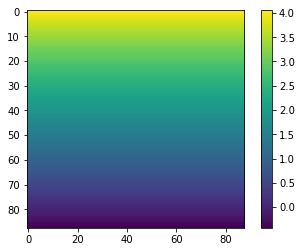

In [271]:
plt.imshow(log_irrad[:,40,:].T)
plt.colorbar()

In [272]:
discrete_plot.volshow_zoom_correct_scale(s, s, z, results['irrad'], zoom_factor=0)

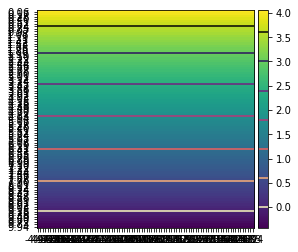

In [273]:
discrete_plot.imshow_with_contours_and_zoom(s, z[::-1], np.log(results['irrad'][0,:,::-1]), zoom_factor=0)

In [274]:
def piecewise_expnt_decay(I0, zmin, zmax, z, k):
    I = np.zeros_like(z)
    nz = len(z)
    dz = (zmax - zmin) / nz
    
    I[0] = I0 * np.exp(-(z[0]-zmin) * k[0])
    
    for i in range(1, nz):
        I[i] = I[i-1] * np.exp(-(k[i-1] + k[i])*dz/2)
    
    return I

In [275]:
print("hi")

hi


In [276]:
np.mean(results['rad'][:,:,0,0])

7.8373794815091484

In [277]:
np.mean(results['irrad'])

11.580273662981616

In [278]:
# Perceived irrad
perc_irrad = kelp_analyze.calculate_perceived_irrad(results['p_kelp'], results['irrad'])

# Avg irrad
avg_irrad = np.mean(results['irrad'], axis=(0, 1))

# No Kelp
no_kelp_irrad = I0 * np.exp(-a_water / np.cos(phi_s) * z)

# Simple kelp
k_kelp = np.zeros_like(z)
A = frond_lengths**2 / fr # Frond area (m^2)
D = 0.1 # vertical kelp ropes m^-2
k_kelp = -np.log(1-absorptance_kelp*(1-(1-A*D)**num_dens))
simple_kelp_irrad = piecewise_expnt_decay(I0, zmin, zmax, z, a_water + k_kelp)

In [279]:
simple_kelp_irrad

array([ 49.49405448,  48.49747049,  47.52095315,  46.5640984 ,
        45.62651033,  44.707801  ,  43.80759028,  42.92550568,
        42.06118223,  41.21426231,  40.38439548,  39.57123838,
        38.77445455,  37.99371429,  37.22869458,  36.47907887,
        35.74455699,  35.02482502,  34.31958516,  33.62854561,
        32.95142044,  32.28792948,  31.63779819,  31.00075757,
        30.37654403,  29.76489931,  29.16557031,  28.57830906,
        28.00287256,  27.43902273,  26.88652625,  26.34515452,
        25.81468355,  25.29489384,  24.78557032,  24.28650224,
        23.79748311,  23.3183106 ,  22.84878643,  22.38871632,
        21.93790993,  21.49618071,  21.06334591,  20.63922641,
        20.22364675,  19.81643496,  19.41742255,  19.02644443,
        18.64333882,  18.26794721,  17.90011426,  17.5396878 ,
        17.18651867,  16.84046075,  16.50137086,  16.16910869,
        15.84353676,  15.52452036,  15.21192749,  14.90562882,
        14.60549759,  14.31140964,  14.02324328,  13.74

In [280]:
k_kelp

array([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.])

In [281]:
np.min(results['rad'][...,-1])

0.00062897379190629478

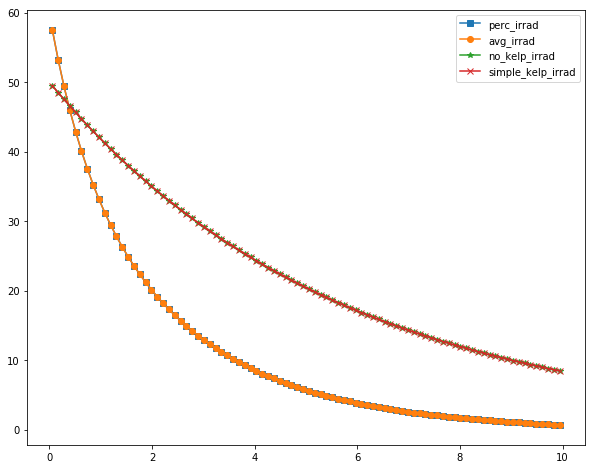

In [284]:
# Plot
plt.figure(figsize=(10,8))
plt.plot(z, perc_irrad, 's-', label='perc_irrad')
plt.plot(z, avg_irrad, 'o-', label='avg_irrad')
plt.plot(z, no_kelp_irrad, '*-', label='no_kelp_irrad')
plt.plot(z, simple_kelp_irrad, 'x-', label='simple_kelp_irrad')
plt.legend()
#plt.yscale('log')

In [283]:
print("hi")

hi


---

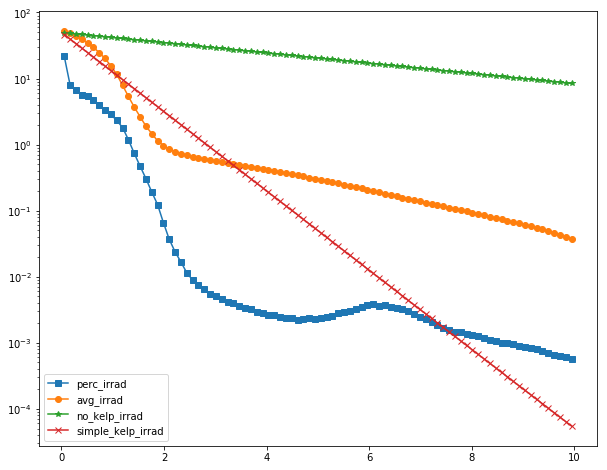

In [226]:
# Plot
plt.figure(figsize=(10,8))
plt.plot(z, perc_irrad, 's-', label='perc_irrad')
plt.plot(z, avg_irrad, 'o-', label='avg_irrad')
plt.plot(z, no_kelp_irrad, '*-', label='no_kelp_irrad')
plt.plot(z, simple_kelp_irrad, 'x-', label='simple_kelp_irrad')
plt.legend()
plt.yscale('log')

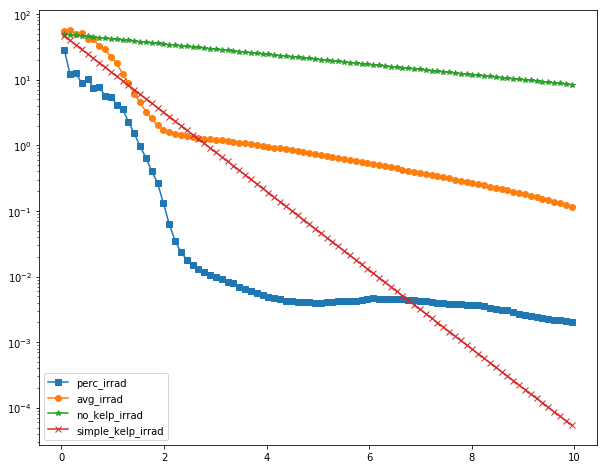

In [210]:
# Plot
plt.figure(figsize=(10,8))
plt.plot(z, perc_irrad, 's-', label='perc_irrad')
plt.plot(z, avg_irrad, 'o-', label='avg_irrad')
plt.plot(z, no_kelp_irrad, '*-', label='no_kelp_irrad')
plt.plot(z, simple_kelp_irrad, 'x-', label='simple_kelp_irrad')
plt.legend()
plt.yscale('log')

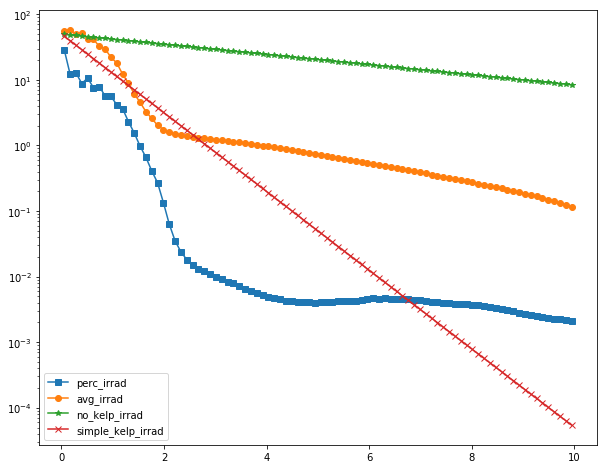

In [194]:
# Plot
plt.figure(figsize=(10,8))
plt.plot(z, perc_irrad, 's-', label='perc_irrad')
plt.plot(z, avg_irrad, 'o-', label='avg_irrad')
plt.plot(z, no_kelp_irrad, '*-', label='no_kelp_irrad')
plt.plot(z, simple_kelp_irrad, 'x-', label='simple_kelp_irrad')
plt.legend()
plt.yscale('log')

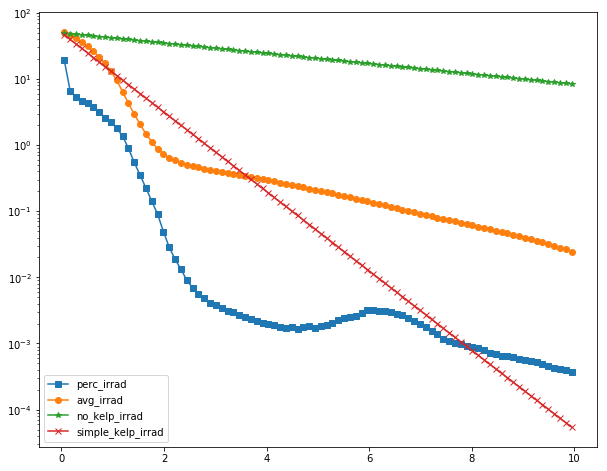

In [179]:
# Plot
plt.figure(figsize=(10,8))
plt.plot(z, perc_irrad, 's-', label='perc_irrad')
plt.plot(z, avg_irrad, 'o-', label='avg_irrad')
plt.plot(z, no_kelp_irrad, '*-', label='no_kelp_irrad')
plt.plot(z, simple_kelp_irrad, 'x-', label='simple_kelp_irrad')
plt.legend()
plt.yscale('log')

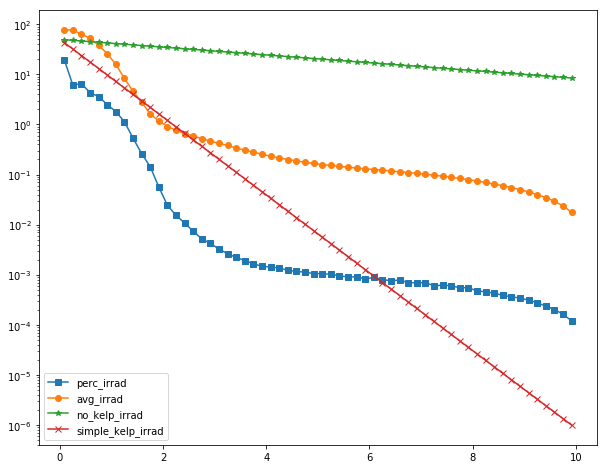

In [42]:
# Plot
plt.figure(figsize=(10,8))
plt.plot(z, perc_irrad, 's-', label='perc_irrad')
plt.plot(z, avg_irrad, 'o-', label='avg_irrad')
plt.plot(z, no_kelp_irrad, '*-', label='no_kelp_irrad')
plt.plot(z, simple_kelp_irrad, 'x-', label='simple_kelp_irrad')
plt.legend()
plt.yscale('log')

# Examine Effective A

In [ ]:
a_list = np.linspace(0, 10, 10)
b = 0.0
ns = 1
na = 2
kelp_profile='none'
max_scatter = 2

a_eff_list = np.zeros_like(a_list)
I0_eff_list = np.zeros_like(a_list)

for i, a in enumerate(a_list):
    # GMRES
    gmres_results = kelp_param.kelp_calculate(
        a,
        b,
        ns,
        na,
        kelp_profile,
        gmres_flag=True,
        num_scatters=0,
        const=const
    )
    true_irrad = gmres_results['irradiance']
    true_avg_irrad = true_irrad.mean(axis=(0,1))
    (I0_eff_list[i], a_eff_list[i]),_ = opt.curve_fit(exp_fun, z, true_avg_irrad, [1, a_water])

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(a_list, a_eff_list**2,y 'C0', label='a_eff')
ax1.plot(a_list, a_list, '--C0', label='Correct')
ax2.plot(a_list, I0_eff_list, 'C1', label='I0_eff')
ax2.plot(a_list, I0+0*a_list, '--C1', label='Correct')
ax1.set_xlabel('Given a')
ax1.set_ylabel('Effective a')
ax2.set_ylabel('Effective I0')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()